In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# GPU 사용 가능하면 GPU로 이동
print('cuda available:',torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cuda available: False


In [2]:
bitcoin_data = pd.read_csv('D:/김홍민/김재윤 교수님 연구실/졸업 준비/clean_bitcoin_data_with_usd_krw_updated.csv')

bitcoin_data.isna().sum()

print(bitcoin_data)

      Unnamed: 0        Date    Close     Open     High      Low  \
0             49  2017-02-19   1048.9   1052.3   1056.5   1037.7   
1             50  2017-02-20   1077.6   1048.9   1081.8   1041.0   
2             51  2017-02-21   1119.0   1077.6   1123.0   1073.5   
3             52  2017-02-22   1120.5   1119.0   1132.3   1094.8   
4             53  2017-02-23   1171.9   1120.5   1181.6   1113.5   
...          ...         ...      ...      ...      ...      ...   
2776        2825  2024-09-26  65175.7  63157.2  65770.9  62693.3   
2777        2826  2024-09-27  65776.3  65168.8  66440.7  64839.2   
2778        2827  2024-09-28  65866.5  65775.6  66232.5  65438.1   
2779        2828  2024-09-29  65607.1  65862.8  66065.7  65436.8   
2780        2829  2024-09-30  63339.2  65607.0  65607.0  62901.1   

      Trade_Volume  change_percent rise_fall        SMA           EMA  \
0            17950           -0.32      rise    951.056    980.292295   
1            31010            2.73   

In [ ]:
bitcoin_data.drop(['Unnamed: 0', 'change_percent'], axis=1, inplace=True) # delete adjusted close
bitcoin_data.rename(columns= {'USD_KRW_Exchange_Rate' : 'EXR'}, inplace= True)
bitcoin_data.head()

,Date,Close,Open,High,Low,Trade_Volume,rise_fall,SMA,EMA,USD_KRW_Exchange_Rate
0,2017-02-19,1048.9,1052.3,1056.5,1037.7,17950,rise,951.056,980.292295,1145.38
1,2017-02-20,1077.6,1048.9,1081.8,1041.0,31010,rise,952.700,981.260531,1145.38
2,2017-02-21,1119.0,1077.6,1123.0,1073.5,57050,rise,954.740,982.631073,1142.89
3,2017-02-22,1120.5,1119.0,1132.3,1094.8,47910,rise,956.484,984.002903,1138.48
4,2017-02-23,1171.9,1120.5,1181.6,1113.5,65740,rise,957.214,985.872526,1133.10


In [4]:
# Convert 'Date' to datetime and set it as index
bitcoin_data['Date'] = pd.to_datetime(bitcoin_data['Date'])
bitcoin_data.set_index('Date', inplace=True)

In [5]:
# 문자형인 종속 변수를 수치형으로 변환
bitcoin_data['rise_fall'] = bitcoin_data['rise_fall'].map({'rise': 1, 'fall': 0})

In [10]:
# Data split based on the provided date threshold
idx = pd.Timestamp('2023-01-01')
train_data = bitcoin_data[bitcoin_data.index < idx]
test_data = bitcoin_data[bitcoin_data.index >= idx]

In [11]:
print('train:',train_data.shape[0])
print('test:',test_data.shape[0])
print(f'train ratio: {(train_data.shape[0] / bitcoin_data.shape[0])*100:.2f}%')

train: 2142
test: 639
train ratio: 77.02%


In [12]:
label_col = 'rise_fall'
features = [col for col in bitcoin_data.columns if col != label_col and col != 'Date']

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data[features])
test_scaled = scaler.transform(test_data[features])

In [13]:
# Convert data into PyTorch tensors
train_features = torch.tensor(train_scaled, dtype=torch.float32)
test_features = torch.tensor(test_scaled, dtype=torch.float32)
train_labels = torch.tensor(train_data[label_col].values, dtype=torch.float32)
test_labels = torch.tensor(test_data[label_col].values, dtype=torch.float32)

In [14]:
# Prepare data for LSTM (sequence data)
def create_sequences(data, labels, seq_length):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        seq = data[i:i + seq_length]  # Take 7 rows of data as input
        label = labels[i + seq_length - 1]  # Label is of the last row in the sequence (7th row)
        sequences.append((seq, label))
    return sequences

In [15]:
# Define sequence length as 7
SEQ_LENGTH = 10

# Create sequences for training and testing
train_sequences = create_sequences(train_features, train_labels, SEQ_LENGTH)
test_sequences = create_sequences(test_features, test_labels, SEQ_LENGTH)

In [16]:
# DataLoader preparation
BATCH_SIZE = 64
train_loader = DataLoader(train_sequences, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_sequences, batch_size=1, shuffle=False)

In [19]:
# Define the LSTM model with Dropout and the target network for WaveBound
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.dropout(hn[-1])
        out = self.fc(out)
        return self.sigmoid(out)

In [20]:
# Model parameters
INPUT_SIZE = len(features)
HIDDEN_SIZE = 50
NUM_LAYERS = 2
OUTPUT_SIZE = 1
DROPOUT_RATE = 0.1
EMA_DECAY = 0.9
EPSILON = 0.2  # Hyperparameter for WaveBound

In [21]:
# Initialize the model and the target network
model = LSTMClassifier(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, dropout_rate=DROPOUT_RATE)
target_model = LSTMClassifier(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, dropout_rate=DROPOUT_RATE)
target_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [22]:
model.to(device)
target_model.to(device)

LSTMClassifier(
  (lstm): LSTM(8, 50, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (sigmoid): Sigmoid()
)

In [23]:
# Function to evaluate accuracy on the test dataset
def evaluate_accuracy(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            predicted = (outputs > 0.5).float()  # Sigmoid threshold at 0.5
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [24]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)

In [25]:
# Training loop with loss tracking, WaveBound regularization, and target model update
EPOCHS = 2000
train_losses = []

best_accuracy = 0.0

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    
    # Use tqdm to create a progress bar for the training loop
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False)
    
    for sequences, labels in progress_bar:
        sequences, labels = sequences.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels.unsqueeze(1))
        
        # Compute the target model's output and its loss
        with torch.no_grad():
            target_outputs = target_model(sequences)
            target_loss = criterion(target_outputs, labels.unsqueeze(1))
        
        # Apply WaveBound regularization to the loss
        wavebound_loss = torch.abs(loss - (target_loss - EPSILON)) + (target_loss - EPSILON)
        
        # Backpropagation and optimization
        wavebound_loss.backward()
        optimizer.step()
        train_loss += wavebound_loss.item()
        
        # Update tqdm progress bar with the current loss
        progress_bar.set_postfix(loss=wavebound_loss.item())
    
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    if (epoch + 1) % 50 == 0:  # Evaluate test accuracy every 50 epochs
        test_accuracy = evaluate_accuracy(model, test_loader, device)
        print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {avg_train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
        
        # If current test accuracy is the best, save the model
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), "lstm_wavebound.pth")
            print(f'Best model saved with accuracy: {best_accuracy:.4f}')
    
    # Update target model using EMA of the source model's parameters
    for target_param, model_param in zip(target_model.parameters(), model.parameters()):
        target_param.data = EMA_DECAY * target_param.data + (1 - EMA_DECAY) * model_param.data

Epoch 50/2000, Loss: 0.6857, Test Accuracy: 0.4937
Best model saved with accuracy: 0.4937


Epoch 100/2000, Loss: 0.6773, Test Accuracy: 0.5333
Best model saved with accuracy: 0.5333


Epoch 150/2000, Loss: 0.6613, Test Accuracy: 0.4905


Epoch 200/2000, Loss: 0.6530, Test Accuracy: 0.4921


Epoch 250/2000, Loss: 0.6393, Test Accuracy: 0.4952


Epoch 300/2000, Loss: 0.6285, Test Accuracy: 0.4873


Epoch 350/2000, Loss: 0.6173, Test Accuracy: 0.5286


Epoch 400/2000, Loss: 0.6196, Test Accuracy: 0.4889


Epoch 450/2000, Loss: 0.5955, Test Accuracy: 0.5063


Epoch 500/2000, Loss: 0.5687, Test Accuracy: 0.4937


Epoch 550/2000, Loss: 0.5417, Test Accuracy: 0.4873


Epoch 600/2000, Loss: 0.5015, Test Accuracy: 0.4857


Epoch 650/2000, Loss: 0.4700, Test Accuracy: 0.4825


Epoch 700/2000, Loss: 0.4809, Test Accuracy: 0.4825


Epoch 750/2000, Loss: 0.4509, Test Accuracy: 0.4968


Epoch 800/2000, Loss: 0.4321, Test Accuracy: 0.5079


Epoch 850/2000, Loss: 0.4407, Test Accuracy: 0.4921


Epoch 900/2000, Loss: 0.3909, Test Accuracy: 0.4873


Epoch 950/2000, Loss: 0.3434, Test Accuracy: 0.4921


Epoch 1000/2000, Loss: 0.3575, Test Accuracy: 0.4905


Epoch 1050/2000, Loss: 0.3152, Test Accuracy: 0.4968


Epoch 1100/2000, Loss: 0.3105, Test Accuracy: 0.4921


Epoch 1150/2000, Loss: 0.2820, Test Accuracy: 0.4937


Epoch 1200/2000, Loss: 0.2627, Test Accuracy: 0.4889


Epoch 1250/2000, Loss: 0.2445, Test Accuracy: 0.4905


Epoch 1300/2000, Loss: 0.2376, Test Accuracy: 0.5000


Epoch 1350/2000, Loss: 0.2099, Test Accuracy: 0.4984


Epoch 1400/2000, Loss: 0.2495, Test Accuracy: 0.4873


Epoch 1450/2000, Loss: 0.1744, Test Accuracy: 0.4921


Epoch 1500/2000, Loss: 0.1890, Test Accuracy: 0.4873


Epoch 1550/2000, Loss: 0.1874, Test Accuracy: 0.4968


Epoch 1600/2000, Loss: 0.1651, Test Accuracy: 0.4857


Epoch 1650/2000, Loss: 0.1507, Test Accuracy: 0.4825


Epoch 1700/2000, Loss: 0.1431, Test Accuracy: 0.4857


Epoch 1750/2000, Loss: 0.1082, Test Accuracy: 0.4794


Epoch 1800/2000, Loss: 0.1688, Test Accuracy: 0.5048


Epoch 1850/2000, Loss: 0.1337, Test Accuracy: 0.5000


Epoch 1900/2000, Loss: 0.1555, Test Accuracy: 0.4905


Epoch 1950/2000, Loss: 0.1080, Test Accuracy: 0.4889


Epoch 2000/2000, Loss: 0.1223, Test Accuracy: 0.5032


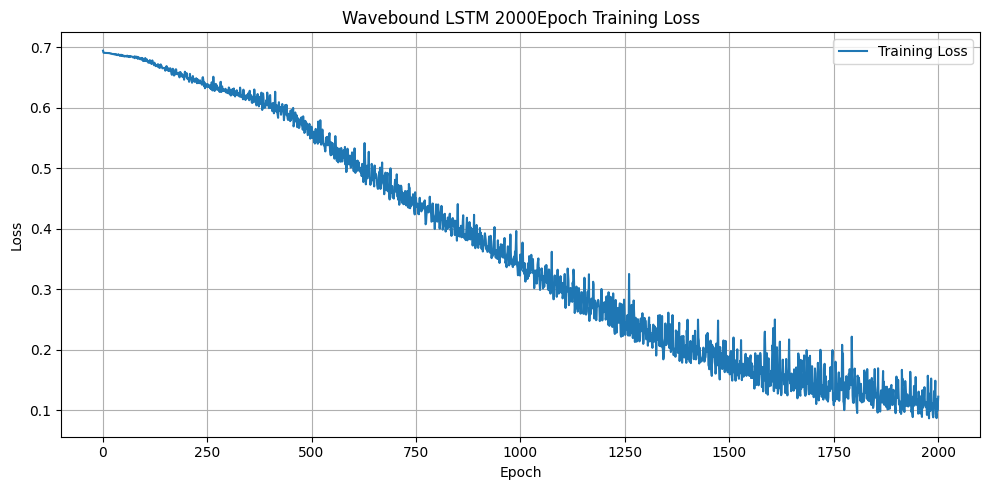

In [26]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.title('Wavebound LSTM 2000Epoch Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig('training_loss_wavebound.png')
plt.show()

In [27]:
# Load the saved model for testing
model = LSTMClassifier(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, dropout_rate=DROPOUT_RATE)
model.load_state_dict(torch.load("lstm_wavebound.pth"))
model.to(device)
model.eval()
print(f"Model loaded from lstm_wavebound.pth")

Model loaded from lstm_wavebound.pth


C:\Users\johnkim\AppData\Local\Temp\ipykernel_1640\1131385456.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lstm_wavebound.pth"))


In [28]:
predictions = []
# Evaluation on test data
correct = 0
total = 0
with torch.no_grad():
    for sequences, labels in tqdm(test_loader, desc='Testing', leave=False):
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)
        predicted = (outputs >= 0.5).float()
        predictions.extend([int(pred.item()) for pred in predicted])
        
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()

accuracy = correct / total
print(f'Wavebound LSTM Test Accuracy: {accuracy * 100:.2f}%')

Wavebound LSTM Test Accuracy: 53.33%


In [29]:
# Assuming `predictions` is a list of predicted values and `test_data` contains the dates.
# Create a DataFrame with the dates and predictions
predictions_df = pd.DataFrame({
    'Date': test_data.index[-len(predictions):],  # Align the dates with predictions
    'Predictions': predictions
})

# Save the DataFrame to a CSV file
predictions_df.to_csv('predictions_with_dates.csv', index=False)

print("Predictions saved to 'predictions_with_dates.csv'")


Predictions saved to 'predictions_with_dates.csv'


In [30]:
import pandas as pd
import os


result_folder = 'D:/김홍민/김재윤 교수님 연구실/졸업 준비/병아리'

# Function to process trading data
def process_trading_data(df):
    # 초기화
    buy_price = None
    sell_price = None
    holding = False
    df['Unrealized_profit'] = 0
    df['Cumulative_Profit'] = 0  # 누적 이익 초기화
    current_profit = 0
    initial_price = None
    for index, row in df.iterrows():
        action = row['action']
        profit = 0

        if action == 'Long':
            buy_price = row['Close']  # Long 시, 매수 가격을 설정
            holding = True
            if initial_price is None:  # 초기 가격 설정
                initial_price = buy_price
        elif action == 'Short':
            sell_price = row['Close']  # Short 시, 매도 가격을 설정
            holding = True
            if initial_price is None:  # 초기 가격 설정
                initial_price = sell_price
        elif action == 'Holding' and holding and buy_price is not None:
            df.at[index, 'Unrealized_profit'] = (row['Close'] - buy_price)
        elif action == 'Holding' and holding and sell_price is not None:
            df.at[index, 'Unrealized_profit'] = (sell_price - row['Close'])
        elif action == 'Exit' and holding and buy_price is not None:
            df.at[index, 'Unrealized_profit'] = (row['Close'] - buy_price) - 0.01
            profit = df.at[index, 'Unrealized_profit']
            df.at[index, 'Cumulative_Profit'] = current_profit + profit  # 누적 이익 업데이트
            current_profit = df.at[index, 'Cumulative_Profit']
            buy_price = None
            holding = False
        elif action == 'Exit' and holding and sell_price is not None:
            df.at[index, 'Unrealized_profit'] = (sell_price - row['Close']) - 0.01
            profit = df.at[index, 'Unrealized_profit']
            df.at[index, 'Cumulative_Profit'] = current_profit + profit  # 누적 이익 업데이트
            current_profit = df.at[index, 'Cumulative_Profit']
            sell_price = None
            holding = False
        elif action == 'no action' and holding:
            pass

    # 수익률 계산 및 누적 수익 계산
    df['Cumulative_Return'] = (df['Cumulative_Profit'] / initial_price) * 100
    df['Unrealized_Return'] = (df['Unrealized_profit'] / initial_price) * 100

    # 누적 수익 + 미실현 수익률 컬럼 추가
    df['Unrealized_profit_plus_Cumulative_Profit'] = df['Cumulative_Profit'] + df['Unrealized_profit']
    df['Unrealized_profit_plus_Cumulative_Profit_Return'] = (df['Unrealized_profit_plus_Cumulative_Profit'] / initial_price) * 100
    df['Cum_portfolio'] = df['Cumulative_Profit'] + initial_price
    df['Unreal_Cum_portfolio'] = df['Unrealized_profit'] + initial_price

    # 매매 결과 총 정리
    df['action'] = df['action'].replace('no action', 0).replace('Long', 1).replace('Short', 2).replace('Exit', -1)

    # 거래 횟수 및 승률
    no_trade = len(df[df['action'] == -1]) - len(df[(df['action'] == -1) & (df['Unrealized_profit'] == 0)])
    winning_ratio = len(df[(df['action'] == -1) & (df['Unrealized_profit'] > 0)]) / no_trade if no_trade > 0 else 0

    profit_average = df[(df['action'] == -1) & (df['Unrealized_profit'] > 0)]['Unrealized_profit'].mean()
    loss_average = df[(df['action'] == -1) & (df['Unrealized_profit'] < 0)]['Unrealized_profit'].mean()

    # Payoff Ratio, Profit Factor
    payoff_ratio = profit_average / -loss_average if loss_average < 0 else 0
    profit_factor = -df[(df['action'] == -1) & (df['Unrealized_profit'] > 0)]['Unrealized_profit'].sum() / df[(df['action'] == -1) & (df['Unrealized_profit'] < 0)]['Unrealized_profit'].sum()

    # Maximum Drawdown (MDD) - 전체 데이터
    peak = df['Cum_portfolio'].cummax()  # 각 시점까지의 누적 최고치 추적
    drawdown = (peak - df['Cum_portfolio']) / peak  # 최고점에서 얼마만큼 떨어졌는지 계산
    max_drawdown = drawdown.max() * 100  # 최대 드로우다운(낙폭)을 계산

    peak_unreal = df['Unreal_Cum_portfolio'].cummax()  # 미실현 수익 포함한 포트폴리오의 누적 최고치 추적
    drawdown_unreal = (peak_unreal - df['Unreal_Cum_portfolio']) / peak_unreal  # 미실현 수익 포함한 드로우다운 계산
    portfolio_max_drawdown = drawdown_unreal.max() * 100  # 포트폴리오의 최대 드로우다운 계산
    
    # 누적 수익 및 손실
    max_cum_profit = df[df['Cumulative_Profit'] != 0]['Cumulative_Profit'].max()
    max_cum_loss = df[df['Cumulative_Profit'] != 0]['Cumulative_Profit'].min()
    last_cumulative = df['Cumulative_Profit'].iloc[-1]

    # 요약 데이터 프레임 생성
    summary_data = [[no_trade, winning_ratio, profit_average, loss_average, payoff_ratio, profit_factor, max_drawdown, portfolio_max_drawdown, max_cum_profit, max_cum_loss, last_cumulative]]
    summary_df = pd.DataFrame(summary_data, columns=['No_Trade', 'Winning_Ratio', 'Profit_Average', 'Loss_Average', 'Payoff_Ratio', 'Profit_Factor', 'Max_Drawdown', 'Portfolio_Max_Drawdown', 'Max_Cumulative_Profit', 'Max_Cumulative_Loss', 'Last_Cumulative'])
    
    return summary_df



In [ ]:
# LSTM 예측 결과를 기반으로 action 결정
actions = ['Holding']  # 첫 번째 데이터는 Holding으로 설정
previous_action = 'Holding'  # 첫 번째 행동은 보유로 시작


# 'predictions'는 시퀀스 데이터로 인해 test_data보다 길이가 짧을 수 있으므로 예측의 시작 지점부터 설정
for i in range(1, len(test_data)):
    if i < len(predictions):  # 예측값이 있는 구간에 대해 액션 결정
        if predictions[i] == 1 and previous_action != 'Long':  # 상승 예측 (Long)
            action = 'Long'
        elif predictions[i] <= 0.5 and previous_action != 'Long':  # 
            action = 'Long'
        elif (predictions[i] > 0.5 and previous_action == 'Exit') or (predictions[i] <= 0.5 and previous_action == 'Long'):
            action = 'Exit'  # 반대 방향 예측 시 Exit   
        else:
            action = 'Holding'  # 변동이 적거나 동일한 예측일 경우
    else:
        action = 'Holding'  # 예측값이 없을 경우 Holding 유지

    actions.append(action)
    previous_action = action

    # Test data에 action 컬럼 추가
test_data['action'] = actions

    


C:\Users\johnkim\AppData\Local\Temp\ipykernel_1640\1194531719.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['action'] = actions


In [ ]:
# LSTM 모델의 예측을 기반으로 수익률을 평가하는 함수 호출
summary_df = process_trading_data(test_data)


C:\Users\johnkim\AppData\Local\Temp\ipykernel_1640\113743250.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Unrealized_profit'] = 0
C:\Users\johnkim\AppData\Local\Temp\ipykernel_1640\113743250.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cumulative_Profit'] = 0  # 누적 이익 초기화
C:\Users\johnkim\AppData\Local\Temp\ipykernel_1640\113743250.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.109999999998544

In [33]:

# 성과 지표 출력
print(summary_df)

   No_Trade  Winning_Ratio  Profit_Average  Loss_Average  Payoff_Ratio  \
0       176       0.454545        555.7375   -413.420417      1.344243   

   Profit_Factor  Max_Drawdown  Portfolio_Max_Drawdown  Max_Cumulative_Profit  \
0       1.120202     46.166582               44.339652                4770.64   

   Max_Cumulative_Loss  Last_Cumulative  
0             -5654.96              0.0  
